In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Load AG News dataset
dataset = load_dataset("ag_news")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize function
def tokenize_batch(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)


dataset = dataset.map(tokenize_batch, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


train_loader = DataLoader(dataset["train"], batch_size=64, shuffle=True)
test_loader = DataLoader(dataset["test"], batch_size=64)


Map: 100%|████████████████████████████████████████████████████████████████████████████████| 7600/7600 [00:01<00:00, 7218.66 examples/s]


In [5]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embed(x)                    # [batch, seq, embed_dim]
        _, (h, _) = self.lstm(x)             # h: [1, batch, hidden_dim]
        return self.fc(h[-1])                # [batch, num_classes]

vocab_size = tokenizer.vocab_size
model = LSTMClassifier(vocab_size, embed_dim=128, hidden_dim=128, num_classes=4)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(3):  # train 3 epochs (small but enough to test)
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, labels = batch["input_ids"], batch["label"]
        outputs = model(input_ids)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 1.3695
Epoch 2, Loss: 0.8578
Epoch 3, Loss: 0.3090


In [8]:
def compute_entropy(logits):
    probs = F.softmax(logits, dim=1)
    entropy = -torch.sum(probs * torch.log(probs + 1e-8), dim=1)
    norm_entropy = entropy / torch.log(torch.tensor(probs.size(1), dtype=torch.float))
    return norm_entropy  # [0,1]

model.eval()
all_entropies, all_labels, all_inputs = [], [], []
with torch.no_grad():
    for batch in test_loader:
        logits = model(batch["input_ids"])
        norm_entropy = compute_entropy(logits)
        all_entropies.extend(norm_entropy.tolist())
        all_labels.extend(batch["label"].tolist())
        all_inputs.extend(batch["input_ids"].tolist())


In [11]:
def bucketize(e):
    if e < 0.3: return 0  # very easy
    elif e < 0.6: return 1  # moderate
    elif e < 0.8: return 2  # hard
    else: return 3  # very hard

criticality_labels = [bucketize(e) for e in all_entropies]

In [12]:
class CriticalityModule(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=4):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embed(x)              # [batch, seq, embed_dim]
        x = torch.mean(x, dim=1)       # average pooling over sequence
        x = F.relu(self.fc1(x))
        return self.fc2(x)             # logits over 4 difficulty classes

criticality_model = CriticalityModule(vocab_size, embed_dim=128, hidden_dim=64)


In [13]:
#  dataset for criticality classifier
from torch.utils.data import TensorDataset

inputs_tensor = torch.tensor(all_inputs)
labels_tensor = torch.tensor(criticality_labels)
crit_dataset = TensorDataset(inputs_tensor, labels_tensor)
crit_loader = DataLoader(crit_dataset, batch_size=64, shuffle=True)


crit_criterion = nn.CrossEntropyLoss()
crit_optimizer = optim.Adam(criticality_model.parameters(), lr=1e-3)

for epoch in range(5):
    criticality_model.train()
    total_loss = 0
    for x, y in crit_loader:
        logits = criticality_model(x)
        loss = crit_criterion(logits, y)

        crit_optimizer.zero_grad()
        loss.backward()
        crit_optimizer.step()
        total_loss += loss.item()
    print(f"[Criticality Module] Epoch {epoch+1}, Loss: {total_loss/len(crit_loader):.4f}")


[Criticality Module] Epoch 1, Loss: 0.8653
[Criticality Module] Epoch 2, Loss: 0.6511
[Criticality Module] Epoch 3, Loss: 0.6206
[Criticality Module] Epoch 4, Loss: 0.5716
[Criticality Module] Epoch 5, Loss: 0.5016


Criticality Module Accuracy: 0.83


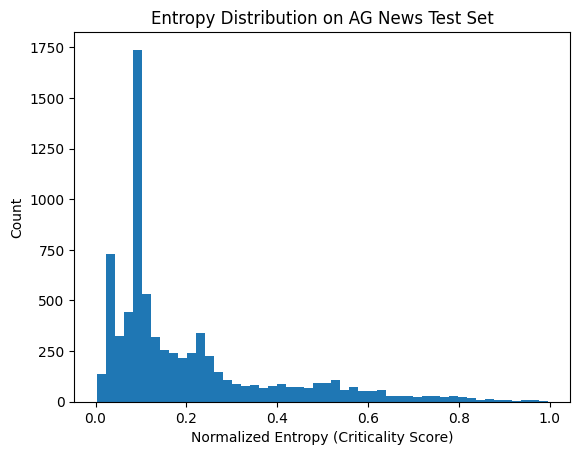

In [14]:
criticality_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in crit_loader:
        logits = criticality_model(x)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Criticality Module Accuracy: {correct/total:.2f}")


plt.hist(all_entropies, bins=50)
plt.xlabel("Normalized Entropy (Criticality Score)")
plt.ylabel("Count")
plt.title("Entropy Distribution on AG News Test Set")
plt.show()


In [19]:
def preprocess_text(text):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    return tokens["input_ids"], tokens["attention_mask"]

def get_entropy_criticality(text, model):
    input_ids, _ = preprocess_text(text)
    with torch.no_grad():
        logits = model(input_ids)
        probs = F.softmax(logits, dim=1)
        entropy = -torch.sum(probs * torch.log(probs + 1e-8), dim=1)
        norm_entropy = entropy / torch.log(torch.tensor(probs.size(1), dtype=torch.float))
    return norm_entropy.item()  # return as Python float

def get_predicted_criticality(text, crit_model):
    input_ids, _ = preprocess_text(text)
    with torch.no_grad():
        logits = crit_model(input_ids)
        preds = torch.argmax(logits, dim=1).item()
    labels = ["Very Easy", "Moderate", "Hard", "Very Hard"]
    return labels[preds]


def test_text(text):
    true_score = get_entropy_criticality(text, model)  # from main LSTM
    pred_bucket = get_predicted_criticality(text, criticality_model)  # from Criticality module
    
    print(f"Input: {text}")
    print(f"True criticality (entropy-based): {true_score:.3f}")
    print(f"Predicted bucket (Criticality Module): {pred_bucket}")


In [20]:
test_text("The stock market saw a major rally today after positive economic news.")
test_text("AI beats human experts in medical diagnosis for rare diseases.")
test_text("asjdh ajksd ajdhs ajshd")  # nonsense, should be "hard"


Input: The stock market saw a major rally today after positive economic news.
True criticality (entropy-based): 0.365
Predicted bucket (Criticality Module): Very Easy
Input: AI beats human experts in medical diagnosis for rare diseases.
True criticality (entropy-based): 0.779
Predicted bucket (Criticality Module): Very Easy
Input: asjdh ajksd ajdhs ajshd
True criticality (entropy-based): 0.992
Predicted bucket (Criticality Module): Very Easy
